In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
df = pd.read_csv("/home/will/Downloads/PTC_10-3.sorted.bam.cov", sep="\t", header=None, names=["genome", "position", "coverage"])
artic = pd.read_csv(
    "/home/will/Desktop/projects/embl/sars-cov-2-metagenomics-simulator/data/protocols/artic_v4_SARS-CoV-2.primer.bed", 
    sep="\t", header=None, names=["genome","start","end","name"], usecols=[i for i in range(4)])
df.head()

,genome,position,coverage
0,MN908947.3,1,1
1,MN908947.3,2,1
2,MN908947.3,3,1
3,MN908947.3,4,1
4,MN908947.3,5,1


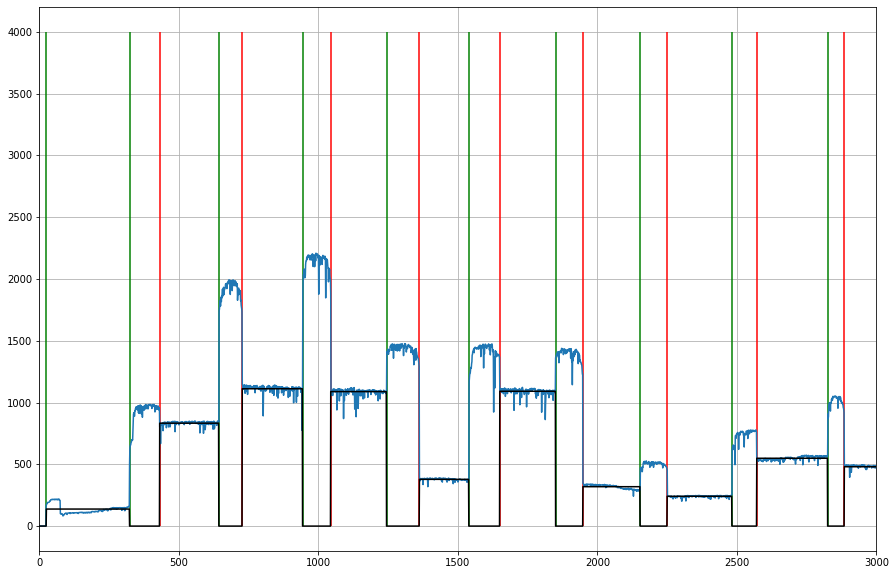

In [145]:
plt.figure(figsize=(15, 10))
plt.subplot(111)
plt.plot(df['coverage'])
plt.vlines([artic['left_start']], ymin=0, ymax=4000, color="g")
plt.vlines([artic['right_end']], ymin=0, ymax=4000, color="r")
plt.plot(mydata, color="black")
n = 0
plt.xlim(n+0, n+3000)
plt.grid()

In [103]:
COVERAGE_VECTOR = np.array(df["coverage"])

array([1, 1, 1, ..., 0, 0, 0])

In [100]:
def add_cols(df):
    # split the column "name" to extract useful data
    df["amplicon_number"] = df["name"].apply(lambda x: int(x.split("_")[1]))
    df["handedness"] = df["name"].apply(lambda x: x.split("_")[2])
    df["is_alt"] = df["name"].apply(lambda x: len(x.split("_")) > 3)
    df = pd.merge(
        df.loc[df["handedness"] == "LEFT"], 
        df.loc[df["handedness"] == "RIGHT"], 
        on=["amplicon_number", "is_alt"]
    )
    

    # rename the columns to more understandable names
    
    df = pd.DataFrame(
        df[["genome_x", "amplicon_number", "is_alt", "name_x",
        "start_x", "end_y"]]
    )

    df = df.rename(columns={
        "name_x":"name",
        "genome_x":"ref", 
        "start_x":"left_start", 
        "end_y":"right_end"})
    
    return df
artic = add_cols(artic)


In [101]:
artic["next_start"] = artic["left_start"].shift(-1)
artic["next_start"] = artic["next_start"].fillna(artic["right_end"])
artic["prev_end"] = artic["right_end"].shift(1)
artic["prev_end"] = artic["prev_end"].fillna(artic["left_start"])

In [107]:
artic["mean_cov"] = artic.apply(lambda x: np.mean(COVERAGE_VECTOR[int(x['prev_end']):int(x['next_start'])]), axis=1)

In [122]:
mydata = []
row = 0
for i in df['position']:
    if i == artic.loc[row, 'right_end']:
        row += 1
        if row == 99:
            row = 98
    if artic.loc[row, 'prev_end'] < i and artic.loc[row, 'next_start'] > i:
        mydata.append(artic.loc[row, 'mean_cov'])
    else:
        mydata.append(0)
        

In [148]:
artic.head()

,ref,amplicon_number,is_alt,name,left_start,right_end,next_start,prev_end,mean_cov,hyperparameter
0,MN908947.3,1,False,SARS-CoV-2_1_LEFT,25,431,324.0,25.0,137.909699,0.001959
1,MN908947.3,2,False,SARS-CoV-2_2_LEFT,324,727,644.0,431.0,832.873239,0.011832
2,MN908947.3,3,False,SARS-CoV-2_3_LEFT,644,1044,944.0,727.0,1111.594470,0.015791
3,MN908947.3,4,False,SARS-CoV-2_4_LEFT,944,1362,1245.0,1044.0,1088.597015,0.015465
4,MN908947.3,5,False,SARS-CoV-2_5_LEFT,1245,1650,1540.0,1362.0,378.382022,0.005375


In [124]:
len(mydata)

29903

In [147]:
artic['hyperparameter'] = artic['mean_cov']/sum(artic['mean_cov'])
data_to_save = pd.DataFrame(artic[['amplicon_number','hyperparameter']])

In [151]:
data_to_save.to_csv("../example/artic_v4_amplicon_hyperparameter.tsv", sep="\t", index=False)